Chapter 9 – Unsupervised Learning

# Setup

Primeiro, vamos importar alguns módulos comuns, garantir que o MatplotLib plote as figuras em linha e preparar uma função para salvá-las. Também verificamos se o Python 3.5 ou posterior está instalado (embora o Python 2.x possa funcionar, ele está obsoleto, portanto, recomendamos fortemente que você use o Python 3), bem como o Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 é necessário
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 é necessário
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# para tornar a saída deste notebook estável em todas as execuções
np.random.seed(42)

# Para traçar figuras bonitas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Clustering

**Introdução – Classification _vs_ Clustering**

In [12]:
from sklearn.datasets import load_iris

In [13]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


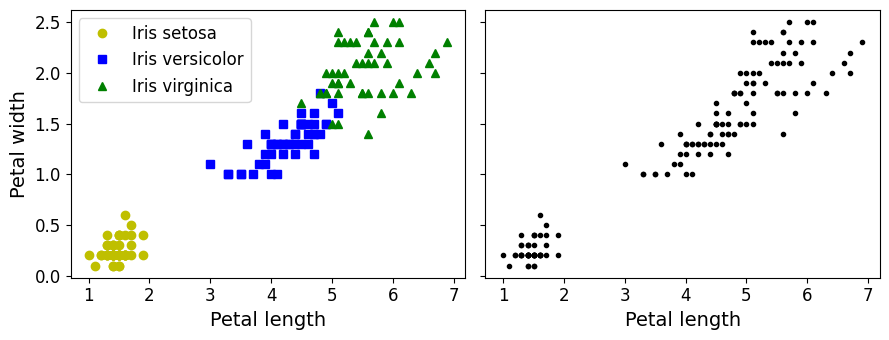

In [14]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

Um modelo de mistura gaussiana (explicado abaixo) pode realmente separar esses aglomerados muito bem (usando todas as quatro características: comprimento e largura da pétala e comprimento e largura da sépala).

In [15]:
from sklearn.mixture import GaussianMixture

In [16]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Vamos mapear cada cluster para uma classe. Em vez de codificar o mapeamento (como é feito no livro, para simplificar), escolheremos a classe mais comum para cada cluster (usando a função `scipy.stats.mode()`):

In [20]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y == class_id], keepdims=True)
    mapping[mode[0]] = class_id

mapping

{np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(0): np.int64(2)}

In [21]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

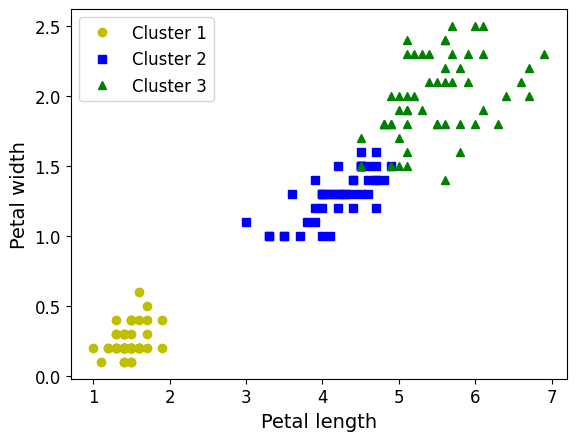

In [22]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [23]:
np.sum(y_pred==y)

np.int64(145)

In [24]:
np.sum(y_pred==y) / len(y_pred)

np.float64(0.9666666666666667)

**Observação**: os resultados neste caderno podem diferir ligeiramente dos resultados do livro. Isso ocorre porque os algoritmos podem, às vezes, sofrer pequenos ajustes entre as versões do Scikit-Learn.

## K-Means

Vamos começar gerando alguns blobs:

In [25]:
from sklearn.datasets import make_blobs

In [26]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [27]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Agora vamos plotá-los:

In [28]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


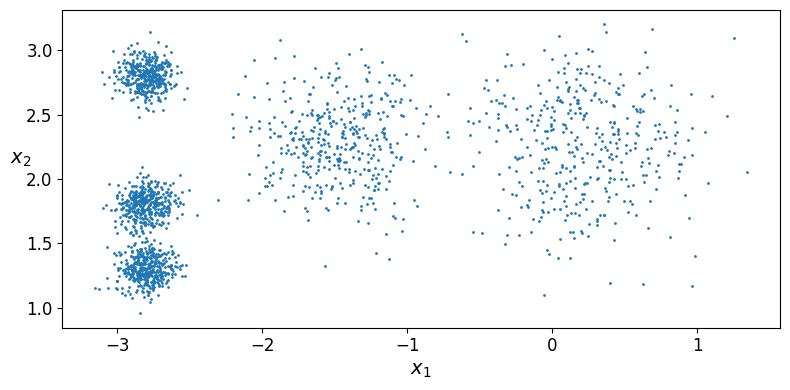

In [29]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

**Ajuste e preveja**

Vamos treinar um clusterer K-Means neste conjunto de dados. Ele tentará encontrar o centro de cada blob e atribuir cada instância ao blob mais próximo:

In [30]:
from sklearn.cluster import KMeans

In [31]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Cada instância foi atribuída a um dos 5 clusters:

In [32]:
y_pred

array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

In [33]:
y_pred is kmeans.labels_

True

E os seguintes 5 _centróides_ (ou seja, centros de cluster) foram estimados:

In [34]:
kmeans.cluster_centers_

array([[-0.066884  ,  2.10378803],
       [-2.79290307,  2.79641063],
       [-2.80214068,  1.55162671],
       [-1.47468607,  2.28399066],
       [ 0.47042841,  2.41380533]])

Observe que a instância `KMeans` preserva os rótulos das instâncias nas quais foi treinada. Um tanto confuso, neste contexto, o _rótulo_ de uma instância é o índice do cluster ao qual a instância é atribuída:

In [35]:
kmeans.labels_

array([2, 2, 4, ..., 1, 4, 2], shape=(2000,), dtype=int32)

Claro, podemos prever os rótulos de novas instâncias:

In [36]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

**Limites de decisão**

Vamos plotar os limites de decisão do modelo. Isso nos dá um _diagrama de Voronoi_:

In [37]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


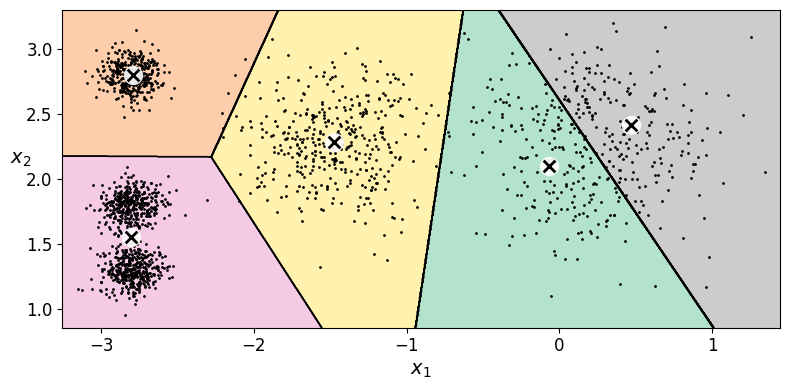

In [38]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Nada mal! Algumas das instâncias perto das bordas provavelmente foram atribuídas ao cluster errado, mas, no geral, parece muito bom.

**Agrupamento rígido _vs_ agrupamento suave**

Em vez de escolher arbitrariamente o cluster mais próximo para cada instância, o que é chamado de _agrupamento rígido_, talvez seja melhor medir a distância de cada instância a todos os 5 centroides. Veja o que o método `transform()` faz:

In [39]:
kmeans.transform(X_new)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

Você pode verificar que esta é de fato a distância euclidiana entre cada instância e cada centróide:

In [40]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.12347236, 2.9042344 , 2.83778629, 1.50178217, 0.62652832],
       [3.06863967, 5.84739223, 5.81943941, 4.48368889, 2.56319474],
       [3.06697984, 0.29040966, 1.4618254 , 1.685008  , 3.51958769],
       [2.95975563, 0.36159148, 0.96879317, 1.54053323, 3.47149865]])

### O Algoritmo K-Means

O algoritmo K-Means é um dos algoritmos de agrupamento mais rápidos e também um dos mais simples:
* Primeiro, inicialize $k$ centróides aleatoriamente: $k$ instâncias distintas são escolhidas aleatoriamente do conjunto de dados e os centróides são colocados em suas posições.
* Repita até a convergência (ou seja, até que os centróides parem de se mover):
    * Atribua cada instância ao centróide mais próximo.
    * Atualize os centróides para que sejam a média das instâncias que lhes são atribuídas.

A classe `KMeans` aplica um algoritmo otimizado por padrão. Para obter o algoritmo K-Means original (apenas para fins educacionais), você deve definir `init="random"`, `n_init=1` e `algorithm="full"`. Esses hiperparâmetros serão explicados a seguir.

Vamos executar o algoritmo K-Means para 1, 2 e 3 iterações, para ver como os centróides se movem:

In [43]:
from sklearn.cluster import KMeans

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="lloyd", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="lloyd", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="lloyd", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)


KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=0)

E vamos traçar isso:

Saving figure kmeans_algorithm_plot


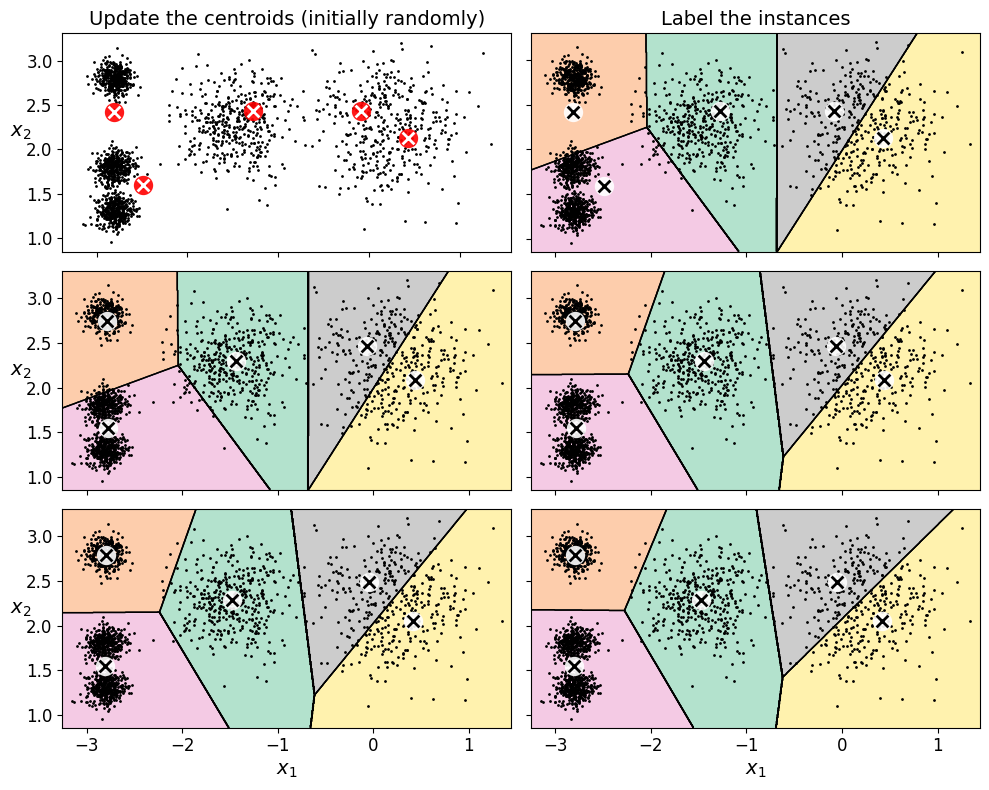

In [44]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**Variabilidade K-Means**

No algoritmo K-Means original, os centroides são inicializados aleatoriamente, e o algoritmo simplesmente executa uma única iteração para melhorar gradualmente os centroides, como vimos acima.

No entanto, um grande problema com essa abordagem é que, se você executar o K-Means várias vezes (ou com diferentes sementes aleatórias), ele pode convergir para soluções muito diferentes, como você pode ver abaixo:

In [46]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


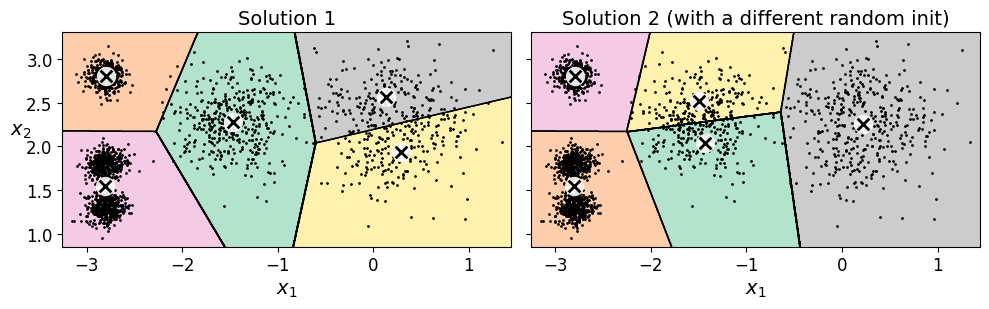

In [48]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="lloyd", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="lloyd", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

### Inércia

Para selecionar o melhor modelo, precisaremos de uma maneira de avaliar o desempenho de um modelo K-Mean. Infelizmente, o agrupamento é uma tarefa não supervisionada, então não temos os alvos. Mas pelo menos podemos medir a distância entre cada instância e seu centroide. Esta é a ideia por trás da métrica _inércia_:

In [49]:
kmeans.inertia_

224.07433122515732

Como você pode verificar facilmente, a inércia é a soma das distâncias quadradas entre cada instância de treinamento e seu centróide mais próximo:

In [50]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

np.float64(224.07433122515744)

O método `score()` retorna a inércia negativa. Por que negativa? Bem, é porque o método `score()` de um preditor deve sempre respeitar a regra "quanto maior, melhor".

In [51]:
kmeans.score(X)

-224.07433122515732

### Inicializações múltiplas

Portanto, uma abordagem para resolver o problema da variabilidade é simplesmente executar o algoritmo K-Means várias vezes com diferentes inicializações aleatórias e selecionar a solução que minimiza a inércia. Por exemplo, aqui estão as inércias dos dois modelos "ruins" mostrados na figura anterior:

In [52]:
kmeans_rnd_init1.inertia_

219.5820150360229

In [53]:
kmeans_rnd_init2.inertia_

239.19226403410448

Como você pode ver, eles têm uma inércia maior que o primeiro modelo "bom" que treinamos, o que significa que eles provavelmente são piores.

Ao definir o hiperparâmetro `n_init`, o Scikit-Learn executa o algoritmo original `n_init` vezes e seleciona a solução que minimiza a inércia. Por padrão, o Scikit-Learn define `n_init=10`.

In [55]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="lloyd", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=2)

Como você pode ver, terminamos com o modelo inicial, que certamente é a solução K-Means ótima (pelo menos em termos de inércia, e assumindo $k=5$).

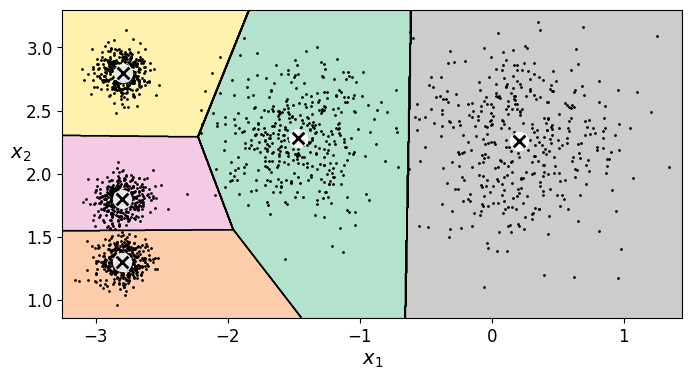

In [56]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Métodos de inicialização do centróide

Em vez de inicializar os centroides de forma totalmente aleatória, é preferível inicializá-los usando o seguinte algoritmo, proposto em um artigo de [2006](https://goo.gl/eNUPw6) por David Arthur e Sergei Vassilvitskii:
* Considere um centroide $c_1$, escolhido uniformemente e aleatoriamente no conjunto de dados.
* Considere um novo centro $c_i$, escolhendo uma instância $\mathbf{x}_i$ com probabilidade: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ onde $D(\mathbf{x}_i)$ é a distância entre a instância $\mathbf{x}_i$ e o centroide mais próximo já escolhido. Essa distribuição de probabilidade garante que instâncias mais distantes dos centroides já escolhidos tenham muito mais probabilidade de serem selecionadas como centroides.

* Repita o passo anterior até que todos os $k$ centróides tenham sido escolhidos.

O restante do algoritmo K-Means++ é apenas um K-Means comum. Com essa inicialização, o algoritmo K-Means tem muito menos probabilidade de convergir para uma solução subótima, portanto, é possível reduzir consideravelmente o `n_init`. Na maioria das vezes, isso compensa amplamente a complexidade adicional do processo de inicialização.

Para definir a inicialização para K-Means++, basta definir `init="k-means++"` (este é, na verdade, o padrão):

In [57]:
KMeans()

KMeans()

In [58]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

### Accelerated K-Means

O algoritmo K-Means pode ser significativamente acelerado evitando muitos cálculos de distância desnecessários: isso é obtido explorando a desigualdade triangular (dados três pontos A, B e C, a distância AC é sempre tal que AC ≤ AB + BC) e mantendo o controle dos limites inferior e superior para distâncias entre instâncias e centróides (veja este [artigo de 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) de Charles Elkan para mais detalhes).

Para usar a variante de K-Means de Elkan, basta definir `algorithm="elkan"`. Observe que ele não suporta dados esparsos, portanto, por padrão, o Scikit-Learn usa `"elkan"` para dados densos e `"full"` (o algoritmo K-Means padrão) para dados esparsos.

In [59]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

11.4 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [61]:
%timeit -n 50 KMeans(algorithm="lloyd", random_state=42).fit(X)

9.05 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


Não há grande diferença neste caso, pois o conjunto de dados é bem pequeno.

### Mini-Batch K-Means

O Scikit-Learn também implementa uma variante do algoritmo K-Means que suporta minilotes (veja [este artigo](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [62]:
from sklearn.cluster import MiniBatchKMeans

In [63]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [64]:
minibatch_kmeans.inertia_

211.6594510571261

Se o conjunto de dados não couber na memória, a opção mais simples é usar a classe `memmap`, assim como fizemos para o PCA incremental no capítulo anterior. Primeiro, vamos carregar o MNIST:

**Aviso:** desde o Scikit-Learn 0.24, `fetch_openml()` retorna um `DataFrame` do Pandas por padrão. Para evitar isso e manter o mesmo código do livro, usamos `as_frame=False`.

In [65]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Em seguida, vamos escrevê-lo em um `memmap`:

In [67]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [68]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

Se os seus dados forem tão grandes que você não consiga usar `memmap`, as coisas ficam mais complicadas. Vamos começar escrevendo uma função para carregar o próximo lote (na vida real, você carregaria os dados do disco):

In [69]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Agora podemos treinar o modelo alimentando-o com um lote de cada vez. Também precisamos implementar múltiplas inicializações e manter o modelo com a menor inércia:

In [70]:
np.random.seed(42)

In [71]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

O K-Means em minilote é muito mais rápido que o K-Means normal:

In [72]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

8.84 ms ± 760 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

72.8 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Isso é *muito* mais rápido! No entanto, seu desempenho costuma ser inferior (maior inércia) e continua se degradando à medida que _k_ aumenta. Vamos plotar a razão de inércia e a razão de tempo de treinamento entre o K-Means do Mini-batch e o K-Means regular:

In [74]:
from timeit import timeit

In [75]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


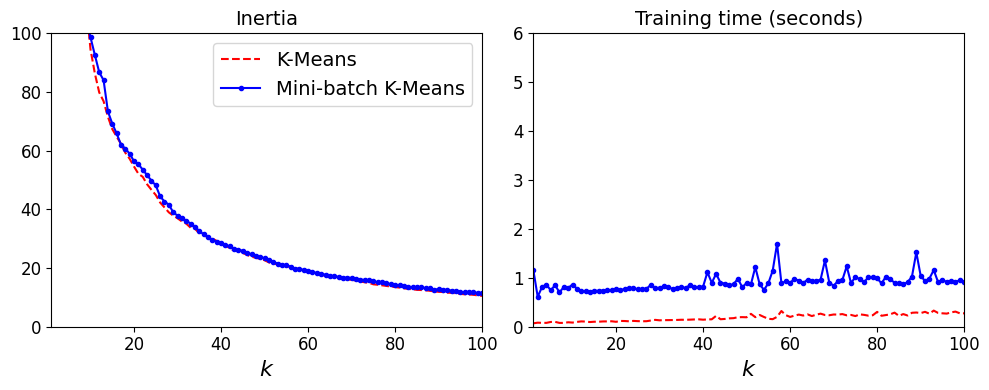

In [76]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### Encontrando o número ideal de clusters

E se o número de clusters fosse definido como um valor menor ou maior que 5?

Saving figure bad_n_clusters_plot


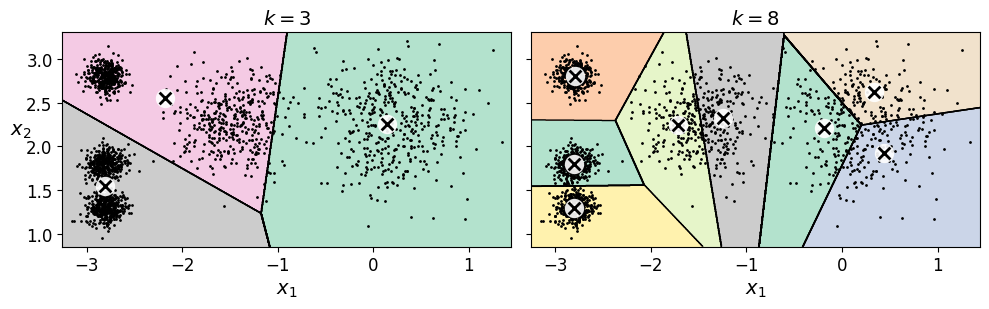

In [77]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Nossa, esses dois modelos não parecem nada bons. E as inércias deles?

In [78]:
kmeans_k3.inertia_

653.2167190021554

In [79]:
kmeans_k8.inertia_

127.13141880461836

Não, não podemos simplesmente tomar o valor de $k$ que minimiza a inércia, visto que ele diminui à medida que aumentamos $k$. De fato, quanto mais clusters houver, mais próxima cada instância estará do seu centroide mais próximo e, portanto, menor será a inércia. No entanto, podemos plotar a inércia como uma função de $k$ e analisar a curva resultante:

In [80]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


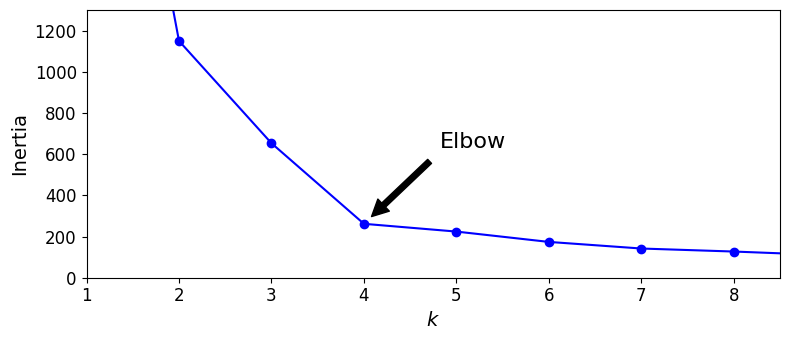

In [81]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

Como você pode ver, há um cotovelo em $k=4$, o que significa que menos clusters do que isso seria ruim, e mais clusters não ajudariam muito e poderiam reduzir os clusters pela metade. Portanto, $k=4$ é uma escolha bastante boa. É claro que neste exemplo não é perfeito, pois significa que os dois pontos no canto inferior esquerdo serão considerados como um único cluster, mas ainda assim é um cluster bastante bom.

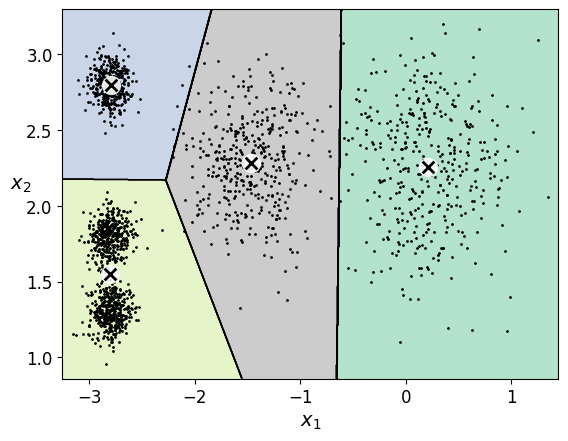

In [82]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Outra abordagem é observar a pontuação da silhueta, que é o coeficiente de silhueta médio de todas as instâncias. O coeficiente de silhueta de uma instância é igual a $(b - a)/\max(a, b)$, onde a é a distância média até as outras instâncias no mesmo cluster (a distância média intracluster) e b é a distância média entre os clusters mais próximos, ou seja, a distância média até as instâncias do cluster mais próximo (definido como aquele que minimiza b, excluindo o próprio cluster da instância). O coeficiente de silhueta pode variar entre -1 e +1: um coeficiente próximo a +1 significa que a instância está bem dentro de seu próprio cluster e longe de outros clusters, enquanto um coeficiente próximo a 0 significa que ela está próxima da fronteira de um cluster e, finalmente, um coeficiente próximo a -1 significa que a instância pode ter sido atribuída ao cluster errado.

Vamos plotar a pontuação da silhueta como uma função de $k$:

In [83]:
from sklearn.metrics import silhouette_score

In [84]:
silhouette_score(X, kmeans.labels_)

np.float64(0.655517642572828)

In [85]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


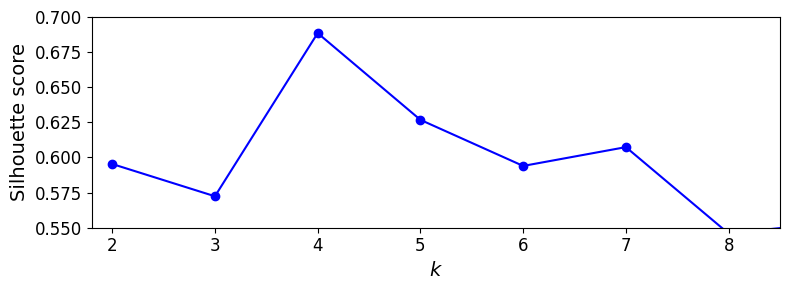

In [86]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Como você pode ver, esta visualização é muito mais rica que a anterior: em particular, embora confirme que $k=4$ é uma escolha muito boa, também ressalta o fato de que $k=5$ também é muito bom.

Uma visualização ainda mais informativa é obtida ao plotar o coeficiente de silhueta de cada instância, classificado pelo cluster ao qual estão atribuídos e pelo valor do coeficiente. Isso é chamado de _diagrama de silhueta_:

Saving figure silhouette_analysis_plot


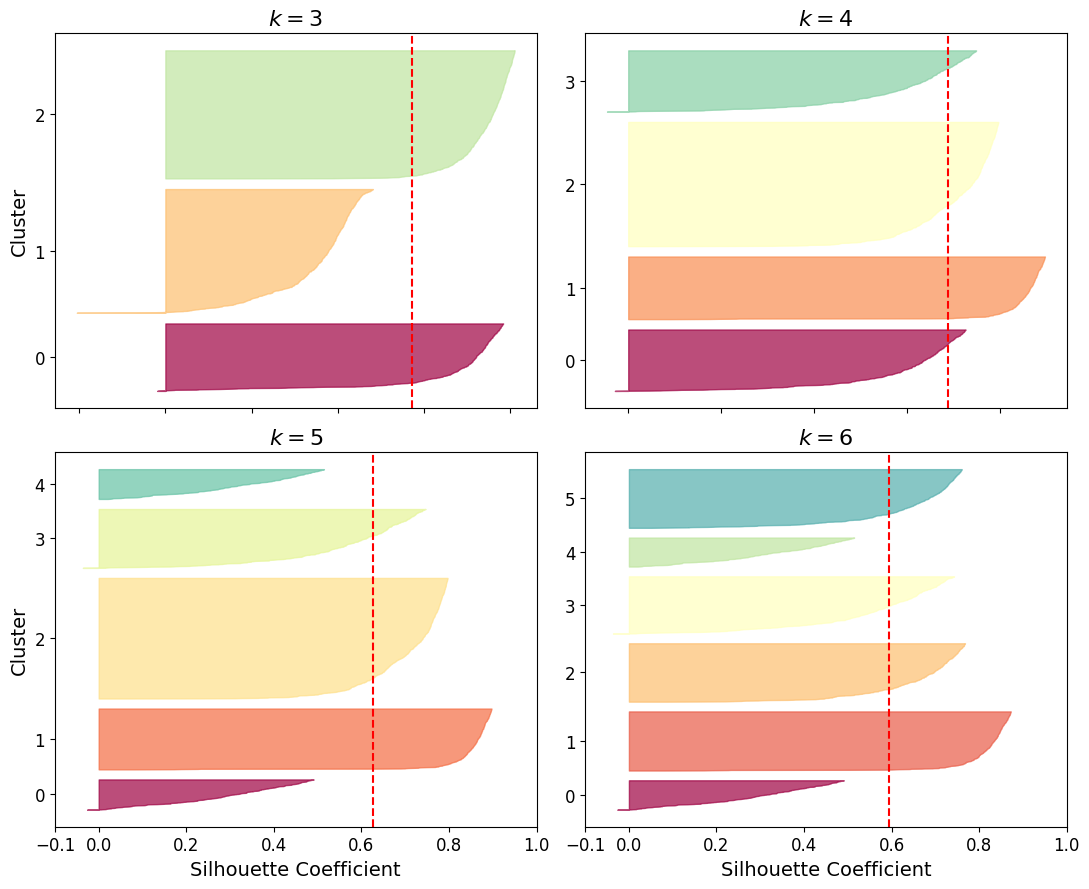

In [87]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Como você pode ver, $k=5$ parece ser a melhor opção aqui, já que todos os clusters têm aproximadamente o mesmo tamanho e todos cruzam a linha tracejada, que representa a pontuação média da silhueta.

## Limites de K-Means

In [88]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

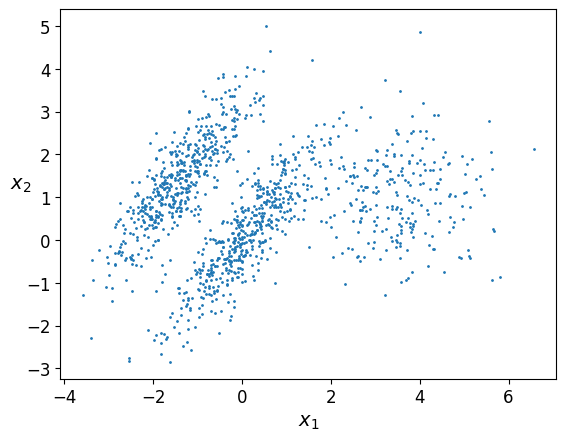

In [89]:
plot_clusters(X)

In [90]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


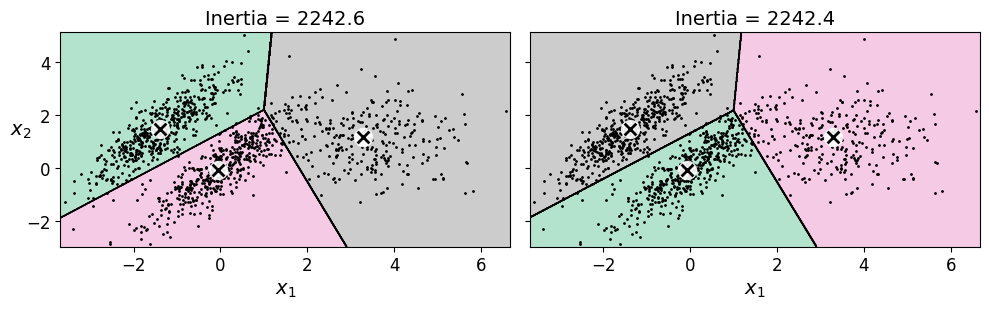

In [91]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

## Usando Clustering para Segmentação de Imagens

In [92]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x260ad894860>)

In [93]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [94]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [95]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


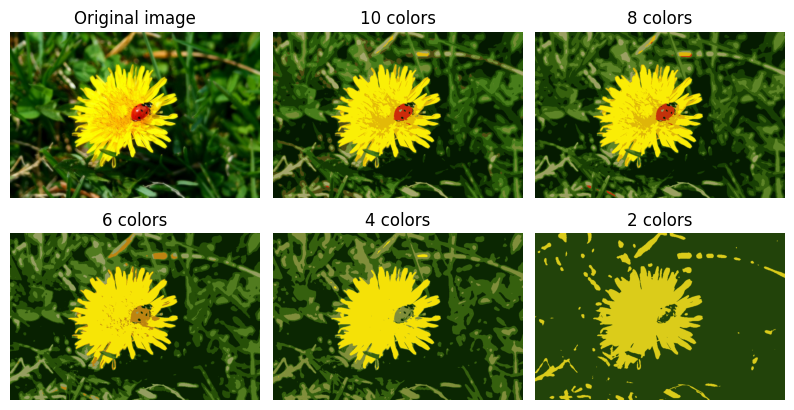

In [96]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

## Usando Clustering para Pré-processamento

Vamos abordar o _conjunto de dados de dígitos_, que é um conjunto de dados simples do tipo MNIST contendo 1.797 imagens 8×8 em tons de cinza representando os dígitos de 0 a 9.

In [97]:
from sklearn.datasets import load_digits

In [98]:
X_digits, y_digits = load_digits(return_X_y=True)

Vamos dividi-lo em um conjunto de treinamento e um conjunto de teste:

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Agora vamos ajustar um modelo de Regressão Logística e avaliá-lo no conjunto de teste:

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [103]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Certo, essa é a nossa linha de base: 96,89% de precisão. Vamos ver se conseguimos melhorar usando o K-Means como etapa de pré-processamento. Criaremos um pipeline que primeiro agrupará o conjunto de treinamento em 50 clusters e substituirá as imagens pelas distâncias até os 50 clusters. Em seguida, aplicaremos um modelo de regressão logística:

In [104]:
from sklearn.pipeline import Pipeline

In [105]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [106]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.98

Quanto a taxa de erro caiu?

In [107]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.3571428571428561

Que tal? Reduzimos a taxa de erro em mais de 35%! Mas escolhemos o número de clusters $k$ de forma completamente arbitrária; certamente podemos fazer melhor. Como o K-Means é apenas uma etapa de pré-processamento em um pipeline de classificação, encontrar um bom valor para $k$ é muito mais simples do que antes: não há necessidade de realizar análise de silhueta ou minimizar a inércia; o melhor valor de $k$ é simplesmente aquele que resulta no melhor desempenho de classificação.

In [108]:
from sklearn.model_selection import GridSearchCV

**Aviso**: a célula a seguir pode levar cerca de 20 minutos para ser executada, ou mais, dependendo do seu hardware.

In [109]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

[CV] END ..............................kmeans__n_clusters=92; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=93; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.6s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.9s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=94; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.9s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=95; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=96; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=97; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=98; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.7s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=99; total time=   0.8s


c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

Vamos ver qual é o melhor número de clusters:

In [110]:
grid_clf.best_params_

{'kmeans__n_clusters': 69}

In [111]:
grid_clf.score(X_test, y_test)

0.9844444444444445

## Usando Clustering para Aprendizagem Semi-Supervisionada

Outro caso de uso para agrupamento é no aprendizado semissupervisionado, quando temos muitas instâncias não rotuladas e muito poucas instâncias rotuladas.

Vamos analisar o desempenho de um modelo de regressão logística quando temos apenas 50 instâncias rotuladas:

In [112]:
n_labeled = 50

In [113]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.8333333333333334

É bem menos do que antes, é claro. Vamos ver como podemos melhorar. Primeiro, vamos agrupar o conjunto de treinamento em 50 grupos e, para cada grupo, encontrar a imagem mais próxima do centroide. Chamaremos essas imagens de imagens representativas:

In [114]:
k = 50

In [115]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Agora vamos plotar essas imagens representativas e rotulá-las manualmente:

Saving figure representative_images_diagram


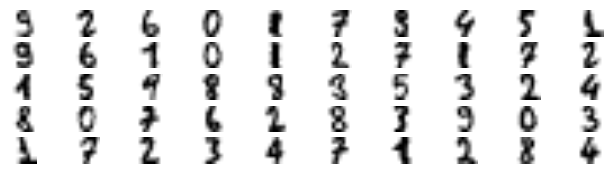

In [116]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [117]:
y_train[representative_digit_idx]

array([9, 2, 6, 0, 1, 7, 9, 4, 5, 1, 9, 6, 1, 0, 1, 2, 7, 1, 7, 2, 1, 5,
       9, 8, 8, 3, 5, 3, 2, 4, 8, 0, 7, 6, 2, 8, 3, 9, 0, 3, 1, 7, 2, 3,
       4, 7, 1, 2, 8, 4])

In [118]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 2, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Agora temos um conjunto de dados com apenas 50 instâncias rotuladas, mas em vez de serem instâncias completamente aleatórias, cada uma delas é uma imagem representativa de seu cluster. Vamos ver se o desempenho é melhor:

In [119]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.11333333333333333

Uau! Saltamos de 83,3% de precisão para 91,3%, embora ainda estejamos treinando o modelo em apenas 50 instâncias. Como rotular instâncias costuma ser custoso e trabalhoso, especialmente quando precisa ser feito manualmente por especialistas, é uma boa ideia fazer com que eles rotulem instâncias representativas em vez de apenas instâncias aleatórias.

Mas talvez possamos ir um passo além: e se propagássemos os rótulos para todas as outras instâncias no mesmo cluster?

In [120]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [121]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [122]:
log_reg.score(X_test, y_test)

0.08444444444444445

Obtivemos um pequeno aumento na precisão. Melhor do que nada, mas provavelmente deveríamos ter propagado os rótulos apenas para as instâncias mais próximas do centroide, porque, ao propagar para o cluster completo, certamente incluímos alguns valores discrepantes. Vamos propagar os rótulos apenas para o 75º percentil mais próximo do centroide:

In [123]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [124]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [125]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [126]:
log_reg.score(X_test, y_test)

0.08

Um pouco melhor. Com apenas 50 instâncias rotuladas (apenas 5 exemplos por classe, em média!), obtivemos um desempenho de 92,7%, que se aproxima do desempenho da regressão logística no conjunto de dados _digits_ totalmente rotulado (que foi de 96,9%).

Isso ocorre porque os rótulos propagados são realmente muito bons: sua precisão é próxima de 96%:

In [127]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

np.float64(0.10427010923535253)

Agora você pode realizar algumas iterações de *aprendizado ativo*:
1. Rotular manualmente as instâncias sobre as quais o classificador tem menos certeza, se possível, separando-as em clusters distintos.
2. Treinar um novo modelo com esses rótulos adicionais.

## DBSCAN

In [128]:
from sklearn.datasets import make_moons

In [129]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [130]:
from sklearn.cluster import DBSCAN

In [131]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [132]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [133]:
len(dbscan.core_sample_indices_)

808

In [134]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [135]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [136]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [137]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [138]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


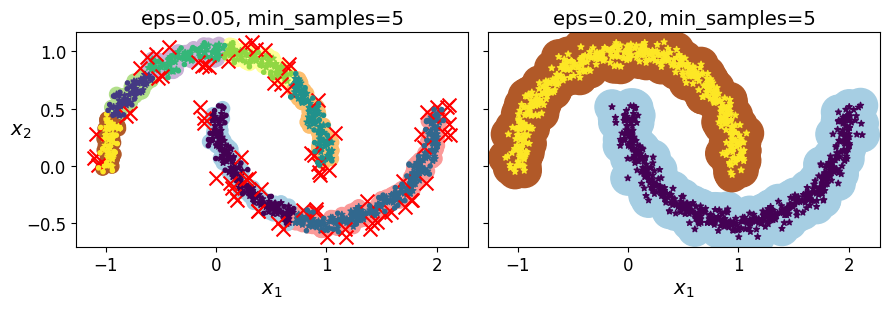

In [139]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [140]:
dbscan = dbscan2

In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [143]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [144]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


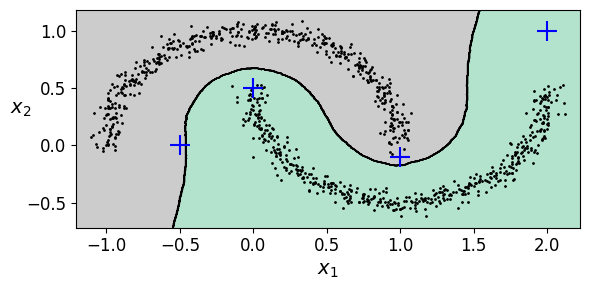

In [145]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [146]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Outros algoritmos de agrupamento

### Agrupamento Espectral

In [147]:
from sklearn.cluster import SpectralClustering

In [148]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [149]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [150]:
np.percentile(sc1.affinity_matrix_, 95)

np.float64(0.04251990648936265)

In [151]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

C:\Users\augusto.matos\AppData\Local\Temp\ipykernel_32484\2175278809.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)


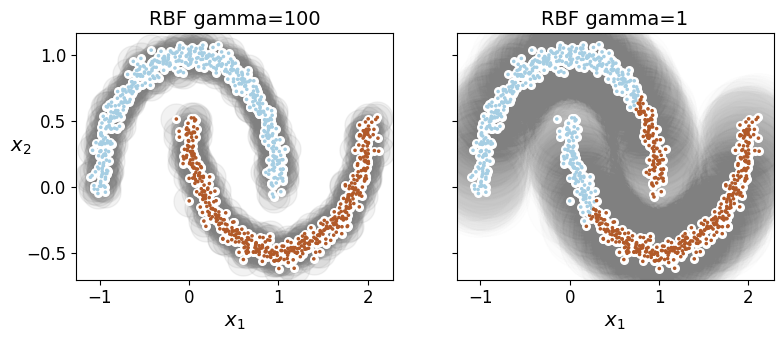

In [152]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agrupamento Aglomerativo

In [153]:
from sklearn.cluster import AgglomerativeClustering

In [154]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [155]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [156]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [157]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Misturas Gaussianas

In [158]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Vamos treinar um modelo de mistura gaussiana no conjunto de dados anterior:

In [159]:
from sklearn.mixture import GaussianMixture

In [160]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Vejamos os parâmetros que o algoritmo EM estimou:

In [161]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [162]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [163]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

O algoritmo realmente convergiu?

In [164]:
gm.converged_

True

Sim, ótimo. Quantas iterações foram necessárias?

In [165]:
gm.n_iter_

4

Agora você pode usar o modelo para prever a qual cluster cada instância pertence (agrupamento rígido) ou as probabilidades de ela ter vindo de cada cluster. Para isso, basta usar o método `predict()` ou o método `predict_proba()`:

In [166]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], shape=(1250,))

In [167]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]], shape=(1250, 3))

Este é um modelo generativo, então você pode amostrar novas instâncias dele (e obter seus rótulos):

In [168]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [169]:
y_new

array([0, 0, 1, 1, 1, 2])

Observe que eles são amostrados sequencialmente de cada cluster.

Você também pode estimar o logaritmo da _função de densidade de probabilidade_ (PDF) em qualquer local usando o método `score_samples()`:

In [170]:
gm.score_samples(X)

array([-2.60786904, -3.57094519, -3.3302143 , ..., -3.51359636,
       -4.39793229, -3.80725953], shape=(1250,))

Vamos verificar se a PDF integra-se a 1 em todo o espaço. Simplesmente pegamos um quadrado grande ao redor dos clusters e o dividimos em uma grade de quadrados minúsculos. Em seguida, calculamos a probabilidade aproximada de que as instâncias sejam geradas em cada quadrado minúsculo (multiplicando a PDF em um canto do quadrado minúsculo pela área do quadrado) e, finalmente, somando todas essas probabilidades. O resultado é muito próximo de 1:

In [171]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

np.float64(0.9999999999225089)

Agora vamos plotar os limites de decisão resultantes (linhas tracejadas) e os contornos de densidade:

In [172]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


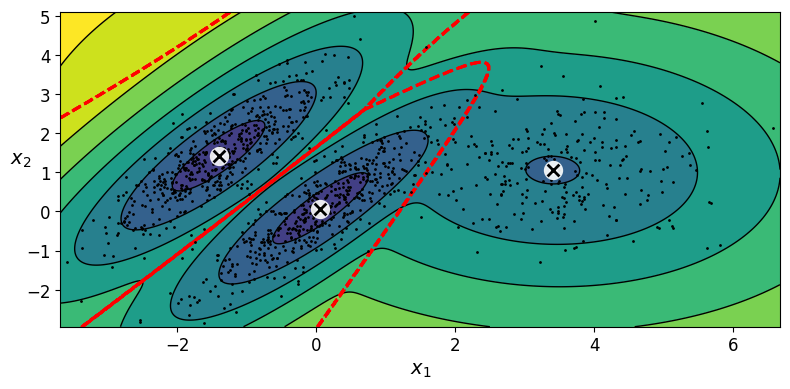

In [173]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

Você pode impor restrições às matrizes de covariância que o algoritmo procura definindo o hiperparâmetro `covariance_type`:
* `"full"` (padrão): sem restrição, todos os clusters podem assumir qualquer forma elipsoidal de qualquer tamanho.
* `"tied"`: todos os clusters devem ter a mesma forma, que pode ser qualquer elipsoide (ou seja, todos compartilham a mesma matriz de covariância).
* `"spherical"`: todos os clusters devem ser esféricos, mas podem ter diâmetros diferentes (ou seja, variâncias diferentes).
* `"diag"`: os clusters podem assumir qualquer forma elipsoidal de qualquer tamanho, mas os eixos do elipsoide devem ser paralelos aos eixos (ou seja, as matrizes de covariância devem ser diagonais).

In [174]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [175]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


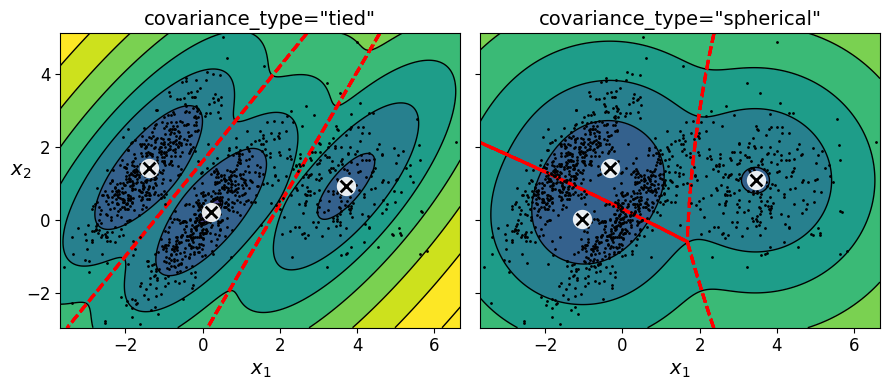

In [176]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

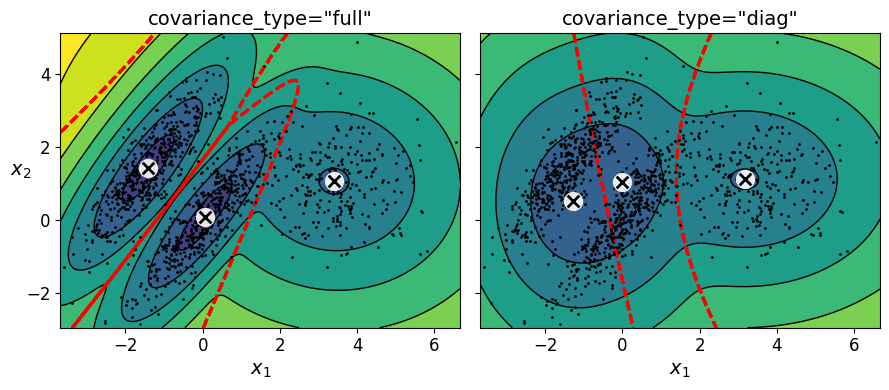

In [177]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Detecção de anomalias usando misturas gaussianas

Misturas Gaussianas podem ser usadas para _detecção de anomalias_: instâncias localizadas em regiões de baixa densidade podem ser consideradas anomalias. Você deve definir qual limite de densidade deseja usar. Por exemplo, em uma empresa de manufatura que tenta detectar produtos defeituosos, a proporção de produtos defeituosos geralmente é bem conhecida. Digamos que seja igual a 4%, então você pode definir o limite de densidade como o valor que resulta em 4% das instâncias localizadas em áreas abaixo desse limite de densidade:

In [178]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


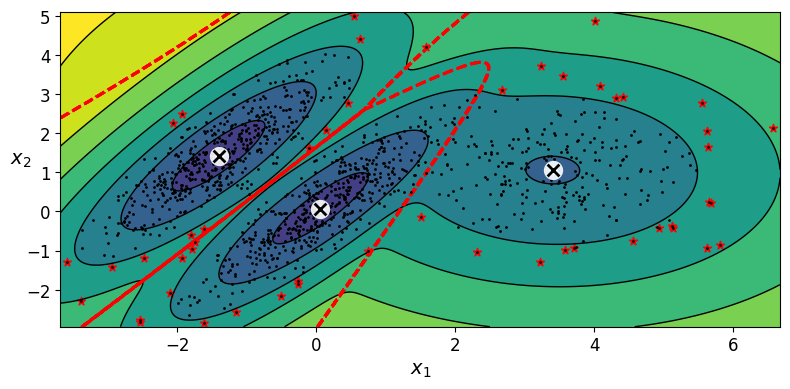

In [179]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## Selecionando o número de clusters

Não podemos usar a inércia ou a pontuação da silhueta porque ambas pressupõem que os clusters são esféricos. Em vez disso, podemos tentar encontrar o modelo que minimiza um critério de informação teórico, como o Critério de Informação Bayesiano (BIC) ou o Critério de Informação de Akaike (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ é o número de instâncias.
* $p$ é o número de parâmetros aprendidos pelo modelo.
* $\hat L$ é o valor maximizado da função de verossimilhança do modelo. Esta é a probabilidade condicional dos dados observados $\mathbf{X}$, dados o modelo e seus parâmetros otimizados.

Tanto o BIC quanto o AIC penalizam modelos que têm mais parâmetros para aprender (por exemplo, mais clusters) e recompensam modelos que se ajustam bem aos dados (ou seja, modelos que dão alta probabilidade aos dados observados).

In [180]:
gm.bic(X)

np.float64(8189.733705221638)

In [181]:
gm.aic(X)

np.float64(8102.5084251066)

Poderíamos calcular o BIC manualmente assim:

In [182]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [183]:
bic, aic

(np.float64(8189.733705221638), np.float64(8102.5084251066))

In [184]:
n_params

17

Há um peso por cluster, mas a soma deve ser igual a 1, então temos um grau de liberdade a menos, daí o -1. Da mesma forma, os graus de liberdade para uma matriz de covariância $n \times n$ não são $n^2$, mas $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Vamos treinar modelos de Mistura Gaussiana com vários valores de $k$ e medir seu BIC:

In [186]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [187]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


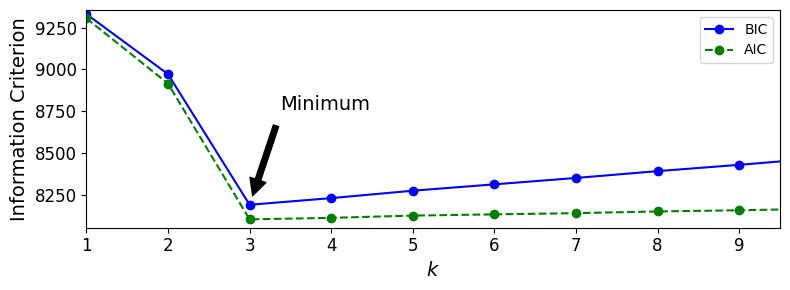

In [188]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Vamos procurar a melhor combinação de valores para o número de clusters e o hiperparâmetro `covariance_type`:

In [190]:
min_bic = np.inf

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [191]:
best_k

3

In [192]:
best_covariance_type

'full'

## Modelos de Mistura Gaussiana Bayesiana

Em vez de procurar manualmente o número ideal de clusters, é possível usar a classe `BayesianGaussianMixture`, que é capaz de atribuir pesos iguais (ou próximos) a zero a clusters desnecessários. Basta definir o número de componentes para um valor que você acredita ser maior que o número ideal de clusters, e o algoritmo eliminará os clusters desnecessários automaticamente.

In [193]:
from sklearn.mixture import BayesianGaussianMixture

In [194]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

O algoritmo detectou automaticamente que apenas 3 componentes são necessários:

In [195]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

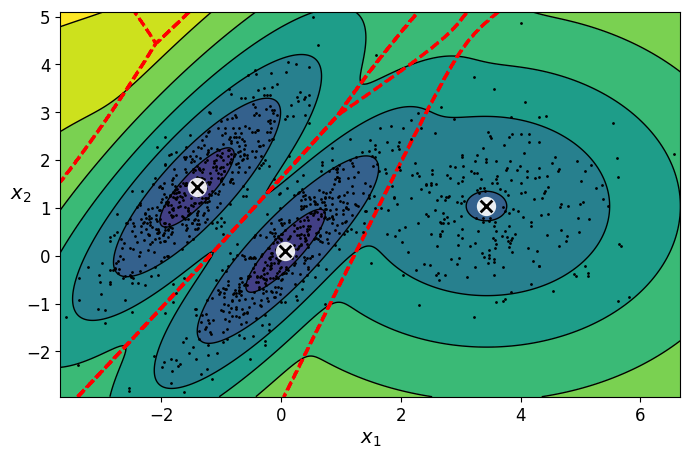

In [196]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [197]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [198]:
np.round(bgm_low.weights_, 2)

array([0.25, 0.26, 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [199]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.37, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


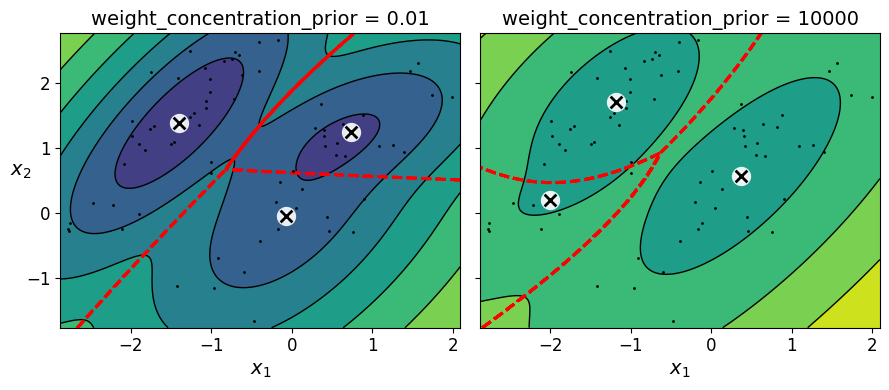

In [200]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Observação: o fato de você ver apenas 3 regiões no gráfico da direita, embora haja 4 centroides, não é um erro. O peso do cluster superior direito é muito maior do que o peso do cluster inferior direito, portanto, a probabilidade de que qualquer ponto nessa região pertença ao cluster superior direito é maior do que a probabilidade de que pertença ao cluster inferior direito.

In [201]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [202]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

c:\Users\augusto.matos\Documents\projetos\Hands-on-Machine-Learning\venv\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


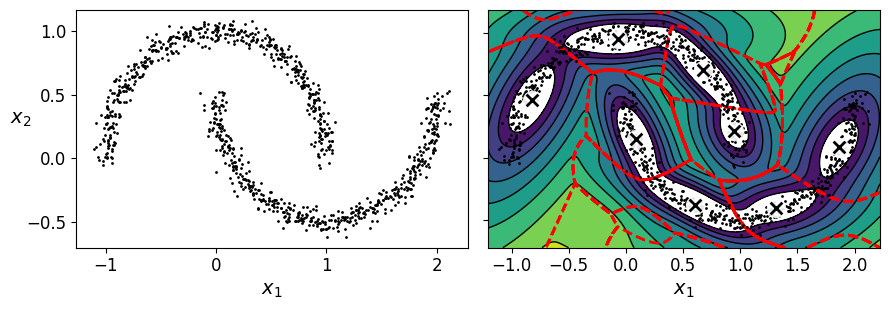

In [203]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Ops, não é ótimo... em vez de detectar 2 aglomerados em forma de lua, o algoritmo detectou 8 aglomerados elipsoidais. No entanto, o gráfico de densidade não parece tão ruim, então pode ser útil para detecção de anomalias.

**Função de verossimilhança**

In [204]:
from scipy.stats import norm

In [205]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


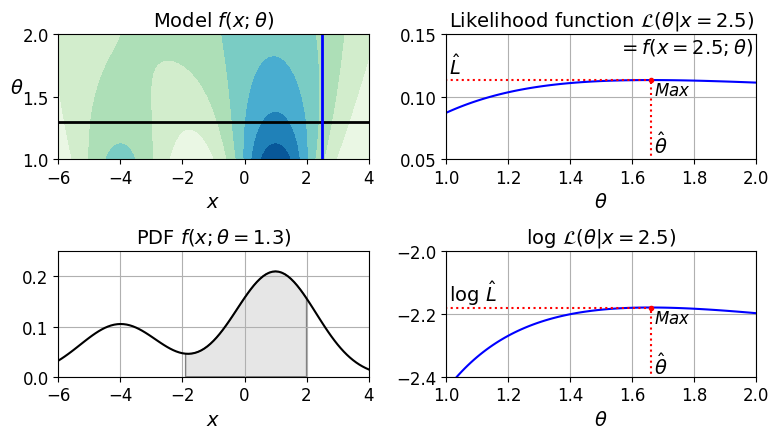

In [206]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

# Soluções de exercícios

## 10. Agrupe o conjunto de dados Olivetti Faces

*Exercício: O conjunto de dados clássico de faces da Olivetti contém 400 imagens de rostos em tons de cinza de 64 × 64 pixels. Cada imagem é achatada em um vetor unidimensional de tamanho 4.096. 40 pessoas diferentes foram fotografadas (10 vezes cada), e a tarefa usual é treinar um modelo que possa prever qual pessoa está representada em cada imagem. Carregue o conjunto de dados usando a função `sklearn.datasets.fetch_olivetti_faces()`.*

In [207]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\augusto.matos\scikit_learn_data


In [208]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [209]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercício: Em seguida, divida-o em um conjunto de treinamento, um conjunto de validação e um conjunto de teste (observe que o conjunto de dados já está dimensionado entre 0 e 1). Como o conjunto de dados é bem pequeno, você provavelmente vai querer usar amostragem estratificada para garantir que haja o mesmo número de imagens por pessoa em cada conjunto.*

In [210]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [211]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


Para acelerar as coisas, reduziremos a dimensionalidade dos dados usando PCA:

In [212]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

np.int64(199)

*Exercício: Em seguida, agrupe as imagens usando K-Means e certifique-se de ter um bom número de agrupamentos (usando uma das técnicas discutidas neste capítulo).*

In [213]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


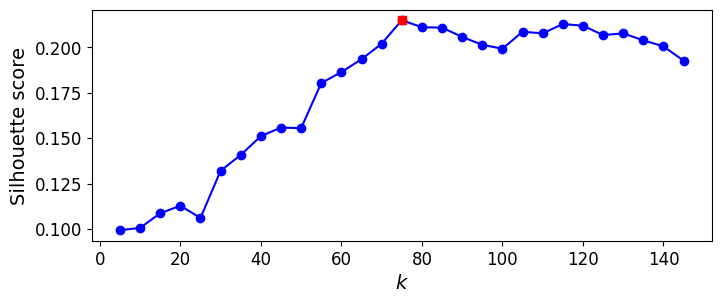

In [214]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [215]:
best_k

75

Parece que o melhor número de grupos é bem alto, 120. Você poderia esperar que fosse 40, já que há 40 pessoas diferentes nas fotos. No entanto, a mesma pessoa pode parecer bem diferente em fotos diferentes (por exemplo, com ou sem óculos, ou simplesmente deslocada para a esquerda ou direita).

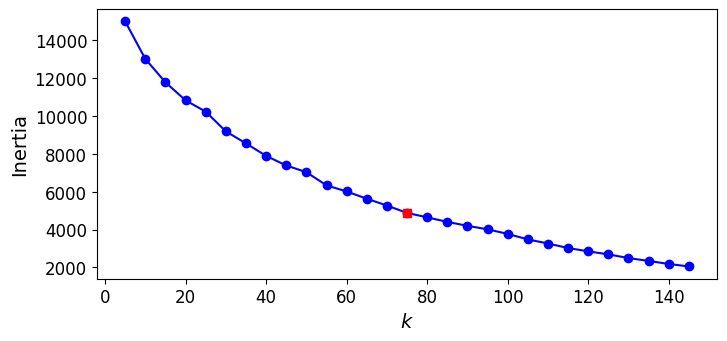

In [216]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

O número ideal de clusters não está claro neste diagrama de inércia, pois não há um cotovelo óbvio, então vamos ficar com k=120.

In [217]:
best_model = kmeans_per_k[best_index]

*Exercício: Visualize os grupos: você vê rostos semelhantes em cada grupo?*

Cluster 0


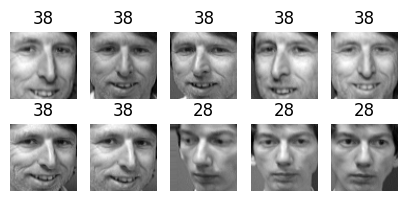

Cluster 1


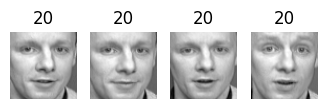

Cluster 2


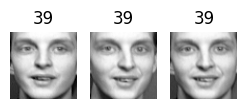

Cluster 3


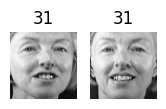

Cluster 4


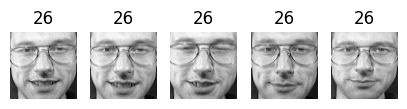

Cluster 5


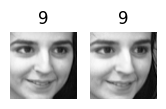

Cluster 6


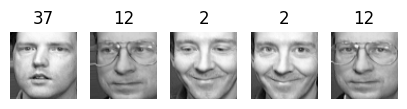

Cluster 7


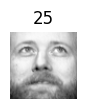

Cluster 8


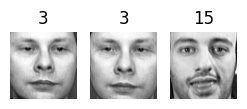

Cluster 9


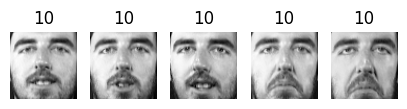

Cluster 10


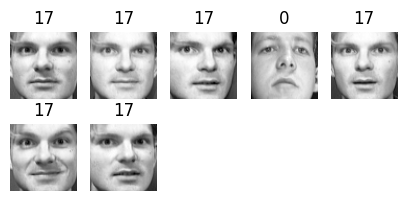

Cluster 11


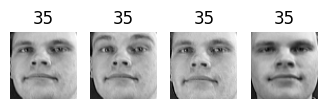

Cluster 12


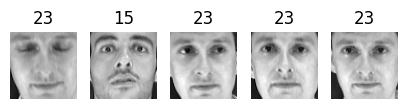

Cluster 13


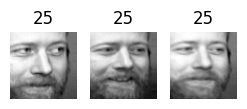

Cluster 14


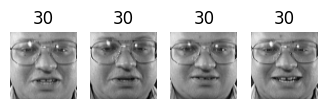

Cluster 15


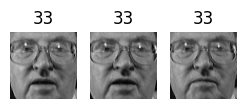

Cluster 16


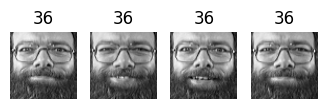

Cluster 17


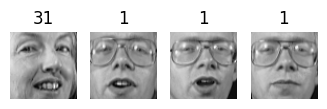

Cluster 18


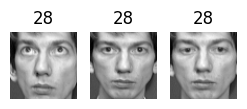

Cluster 19


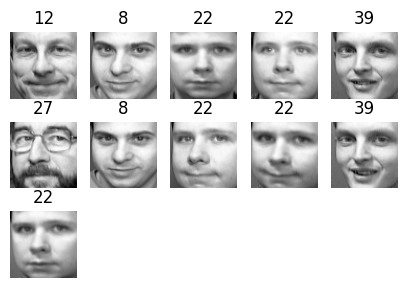

Cluster 20


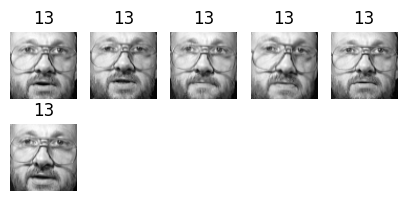

Cluster 21


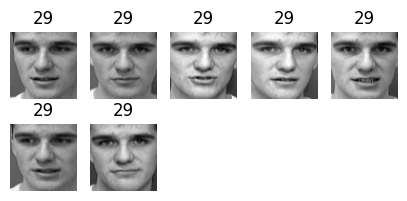

Cluster 22


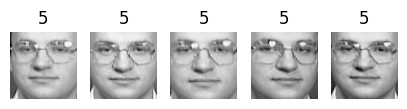

Cluster 23


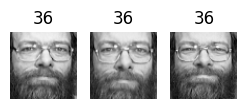

Cluster 24


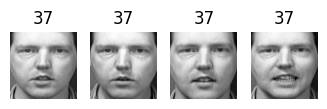

Cluster 25


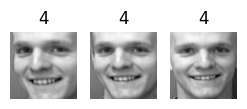

Cluster 26


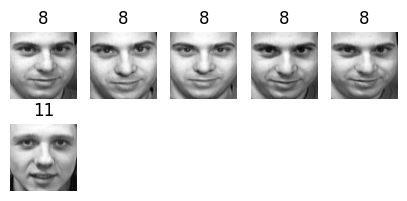

Cluster 27


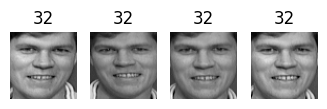

Cluster 28


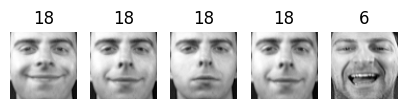

Cluster 29


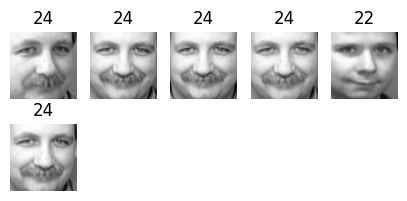

Cluster 30


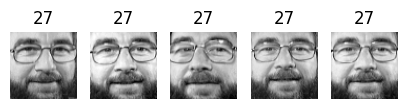

Cluster 31


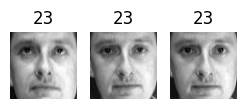

Cluster 32


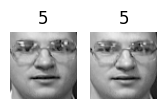

Cluster 33


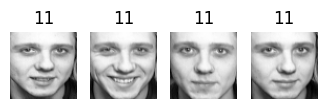

Cluster 34


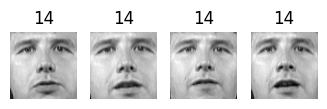

Cluster 35


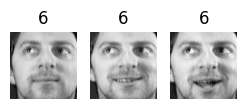

Cluster 36


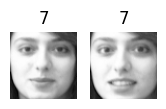

Cluster 37


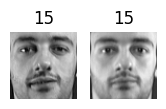

Cluster 38


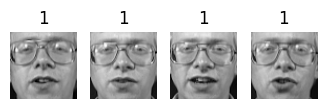

Cluster 39


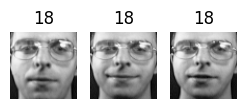

Cluster 40


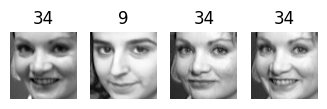

Cluster 41


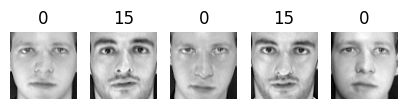

Cluster 42


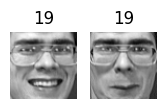

Cluster 43


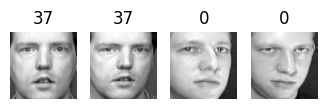

Cluster 44


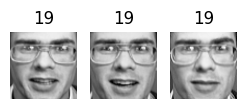

Cluster 45


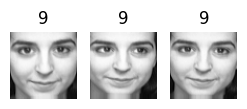

Cluster 46


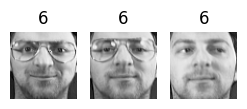

Cluster 47


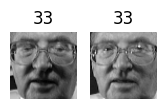

Cluster 48


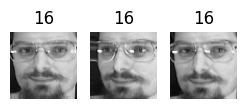

Cluster 49


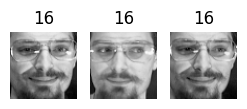

Cluster 50


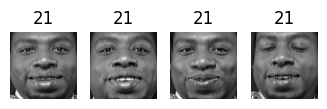

Cluster 51


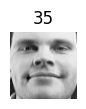

Cluster 52


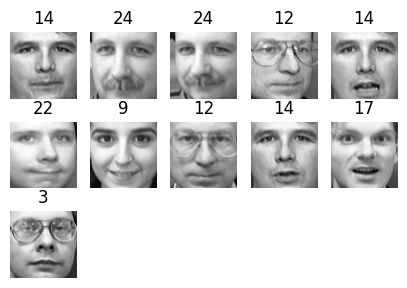

Cluster 53


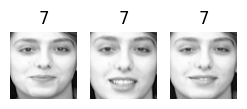

Cluster 54


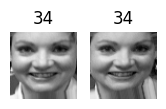

Cluster 55


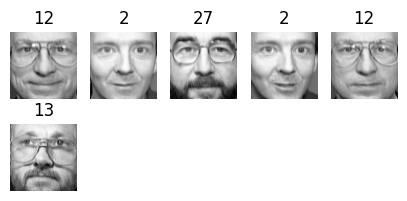

Cluster 56


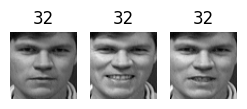

Cluster 57


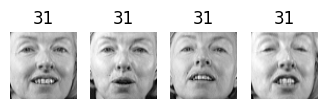

Cluster 58


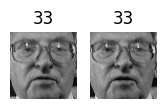

Cluster 59


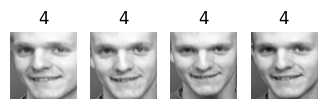

Cluster 60


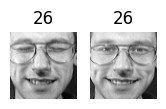

Cluster 61


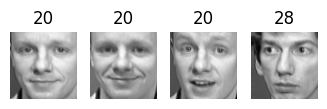

Cluster 62


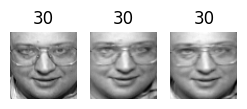

Cluster 63


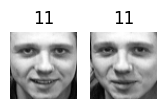

Cluster 64


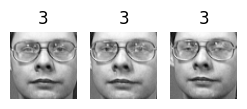

Cluster 65


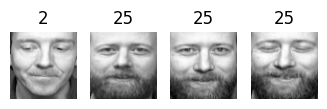

Cluster 66


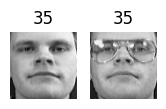

Cluster 67


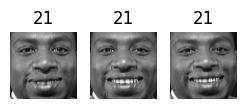

Cluster 68


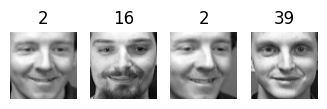

Cluster 69


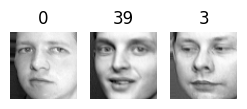

Cluster 70


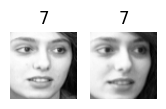

Cluster 71


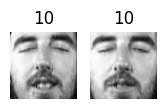

Cluster 72


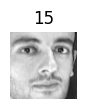

Cluster 73


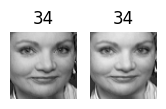

Cluster 74


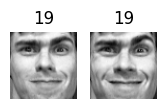

In [218]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

Cerca de 2 em cada 3 clusters são úteis: ou seja, contêm pelo menos 2 fotos, todas da mesma pessoa. No entanto, os demais clusters contêm um ou mais intrusos, ou apenas uma única foto.

Agrupar imagens dessa maneira pode ser impreciso demais para ser diretamente útil ao treinar um modelo (como veremos a seguir), mas pode ser extremamente útil ao rotular imagens em um novo conjunto de dados: geralmente, torna a rotulagem muito mais rápida.

## 11. Usando Clustering como Pré-processamento para Classificação

*Exercício: Continuando com o conjunto de dados de rostos da Olivetti, treine um classificador para prever qual pessoa é representada em cada imagem e avalie-o no conjunto de validação.*

In [219]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9375

*Exercício: Em seguida, use K-Means como uma ferramenta de redução de dimensionalidade e treine um classificador no conjunto reduzido.*

In [220]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7375

Nossa! Isso não é nada melhor! Vamos ver se ajustar o número de clusters ajuda.

*Exercício: Procure o número de clusters que permite ao classificador obter o melhor desempenho: qual desempenho você pode alcançar?*

Poderíamos usar um `GridSearchCV` como fizemos anteriormente neste notebook, mas como já temos um conjunto de validação, não precisamos de validação cruzada K-fold e estamos explorando apenas um único hiperparâmetro, então é mais simples executar um loop manualmente:

In [221]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.4
10 0.4375
15 0.5875
20 0.6
25 0.6625
30 0.6625
35 0.6625
40 0.675
45 0.675
50 0.6875
55 0.75
60 0.6875
65 0.725
70 0.7
75 0.7375
80 0.725
85 0.7625
90 0.775
95 0.775
100 0.7625
105 0.75
110 0.725
115 0.7625
120 0.7625
125 0.7375
130 0.7375
135 0.725
140 0.8
145 0.725


Bem, mesmo ajustando o número de aglomerados, nunca ultrapassamos 80% de precisão. Parece que as distâncias aos centroides dos aglomerados não são tão informativas quanto as imagens originais.

*Exercício: E se você anexar os recursos do conjunto reduzido aos recursos originais (novamente, buscando o melhor número de clusters)?*

In [229]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [230]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.85

Isso é um pouco melhor, mas ainda pior do que sem os recursos de cluster. Os clusters não são úteis para treinar diretamente um classificador neste caso (mas ainda podem ajudar na rotulagem de novas instâncias de treinamento).

## 12. Um modelo de mistura gaussiana para o conjunto de dados Olivetti Faces

*Exercício: Treine um modelo de mistura gaussiana no conjunto de dados de faces da Olivetti. Para acelerar o algoritmo, você provavelmente deve reduzir a dimensionalidade do conjunto de dados (por exemplo, usar ACP, preservando 99% da variância).*

In [231]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [232]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

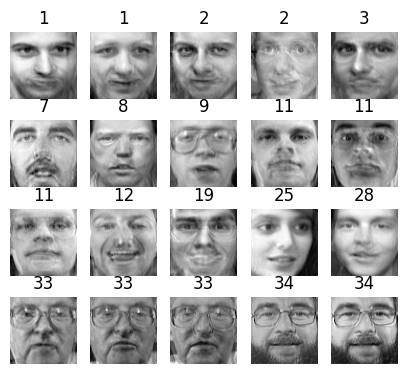

In [233]:
plot_faces(gen_faces, y_gen_faces)

*Exercício: Tente modificar algumas imagens (por exemplo, girar, inverter, escurecer) e veja se o modelo consegue detectar as anomalias (por exemplo, compare a saída do método `score_samples()` para imagens normais e para anomalias).*

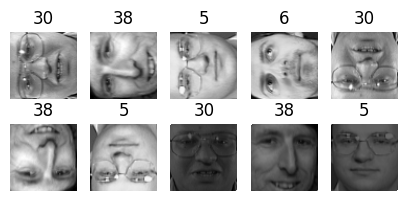

In [234]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [235]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [236]:
gm.score_samples(X_bad_faces_pca)

array([-1.85962685e+07, -1.73013934e+07, -4.15206781e+07, -4.81260280e+07,
       -3.20479461e+07, -1.35426833e+07, -2.92373894e+07, -9.25150127e+07,
       -1.03272456e+08, -5.41697443e+07])

As faces ruins são todas consideradas altamente improváveis ​​pelo modelo de Mistura Gaussiana. Compare isso com as pontuações de algumas instâncias de treinamento:

In [237]:
gm.score_samples(X_train_pca[:10])

array([1163.02020849, 1112.1730837 , 1156.32132816, 1170.67602878,
       1073.69246059, 1139.89252685, 1113.7662975 , 1073.6924482 ,
       1048.17522736, 1048.1752062 ])

## 13. Usando Técnicas de Redução de Dimensionalidade para Detecção de Anomalias

*Exercício: Algumas técnicas de redução de dimensionalidade também podem ser usadas para detecção de anomalias. Por exemplo, pegue o conjunto de dados de faces da Olivetti e reduza-o com ACP, preservando 99% da variância. Em seguida, calcule o erro de reconstrução para cada imagem. Em seguida, pegue algumas das imagens modificadas que você construiu no exercício anterior e observe o erro de reconstrução delas: observe como o erro de reconstrução é muito maior. Se você plotar uma imagem reconstruída, verá o porquê: ela tenta reconstruir uma face normal.*

Já reduzimos o conjunto de dados usando PCA anteriormente:

In [238]:
X_train_pca

array([[-3.78081918e+00,  1.85478926e+00, -5.14404392e+00, ...,
         1.35632366e-01, -2.14082837e-01,  6.11899011e-02],
       [-1.01488476e+01,  1.52754676e+00, -7.66979814e-01, ...,
        -1.23929858e-01, -1.35266602e-01, -2.32773945e-02],
       [ 1.00152912e+01, -2.87729883e+00, -9.19884980e-01, ...,
        -7.26101249e-02, -2.96468008e-03,  1.24892525e-01],
       ...,
       [-2.47586775e+00, -2.95596957e+00,  1.29985762e+00, ...,
         2.09113769e-02,  3.48556712e-02, -1.54325306e-01],
       [ 3.22031212e+00, -5.34897852e+00,  1.39427197e+00, ...,
        -5.75480610e-02, -2.28314146e-01,  1.55574888e-01],
       [ 9.22876894e-01,  3.64702678e+00,  2.26087737e+00, ...,
        -1.36853769e-01, -6.91335127e-02,  6.26790449e-02]],
      shape=(280, 199), dtype=float32)

In [239]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [240]:
reconstruction_errors(pca, X_train).mean()

np.float32(0.00019205351)

In [241]:
reconstruction_errors(pca, X_bad_faces).mean()

np.float32(0.004707354)

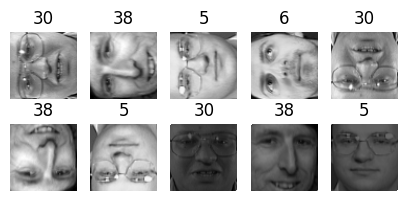

In [242]:
plot_faces(X_bad_faces, y_bad)

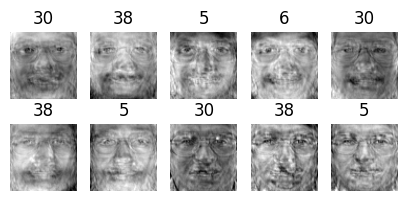

In [243]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)